In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

Hidden Neurons: 8, Validation RMSE: 0.7677
Hidden Neurons: 16, Validation RMSE: 0.7673
Hidden Neurons: 32, Validation RMSE: 0.7667
Hidden Neurons: 64, Validation RMSE: 0.7660

Best Model: 64 neurons
Train RMSE: 0.7775
Validation RMSE: 0.7660
Test RMSE: 0.7494


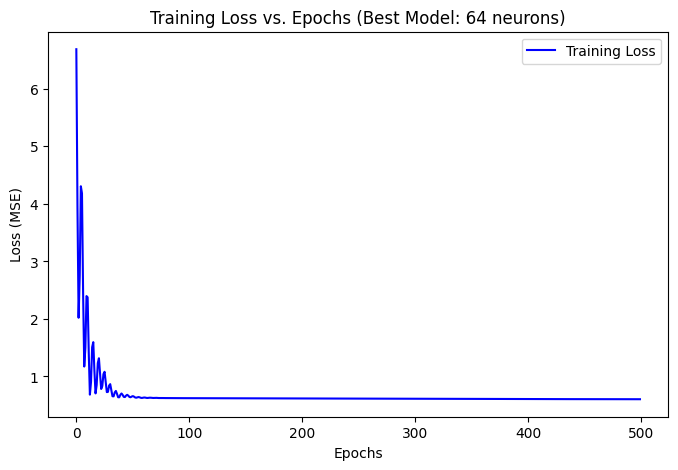

In [4]:
df=pd.read_csv('airquality_updated.csv')
X=df[['PT08.S1(CO)']].values
y=df['CO'].values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

class NeuralNet(nn.Module):
    def __init__(self, hidden_size):
        super(NeuralNet, self).__init__()
        self.hidden = nn.Linear(1, hidden_size)
        self.activation = nn.Sigmoid()
        self.output = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        x = self.hidden(x)
        x = self.activation(x)
        x = self.output(x)
        return x

hidden_sizes = [8, 16, 32, 64]
best_model = None
best_rmse_val = float('inf')
train_losses = {}
for hidden_size in hidden_sizes:
    model = NeuralNet(hidden_size)
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
    
    num_epochs = 500
    loss_history = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(X_train_torch)
        loss = criterion(y_pred_train, y_train_torch)
        loss.backward()
        optimizer.step()
        
        loss_history.append(loss.item())

    model.eval()
    with torch.no_grad():
        y_pred_val = model(X_val_torch)
        rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val.numpy()))

    print(f"Hidden Neurons: {hidden_size}, Validation RMSE: {rmse_val:.4f}")

    
    if rmse_val < best_rmse_val:
        best_rmse_val = rmse_val
        best_model = model
        best_hidden_size = hidden_size
        best_loss_history = loss_history


best_model.eval()
with torch.no_grad():
    y_pred_train = best_model(X_train_torch)
    y_pred_val = best_model(X_val_torch)
    y_pred_test = best_model(X_test_torch)

    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train.numpy()))
    rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val.numpy()))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test.numpy()))

print(f"\nBest Model: {best_hidden_size} neurons")
print(f"Train RMSE: {rmse_train:.4f}")
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Test RMSE: {rmse_test:.4f}")
plt.figure(figsize=(8, 5))
plt.plot(best_loss_history, label="Training Loss", color="blue")
plt.xlabel("Epochs")
plt.ylabel("Loss (MSE)")
plt.title(f"Training Loss vs. Epochs (Best Model: {best_hidden_size} neurons)")
plt.legend()
plt.show()